In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular import *

### Train tabular model

In [3]:
path=Path.home()/'tutorials/hk-horse-racing/data'
# get training set and test set from csv file
train_df=pd.read_csv(path/'train/train.csv',index_col=0,parse_dates=['date'])
test_df = pd.read_csv(path/'test/test.csv',index_col=0,parse_dates=['date'])
# sort test set order by date, race id, and horse number
# this is normal order of official race info
test_df.sort_values(['date','race_id','horse_no'],inplace=True)
df_pred=test_df.copy()

In [4]:
target_test = test_df['finish_time_s']
test_df.drop(columns='finish_time_s',inplace=True)
train_df.shape,test_df.shape

((58432, 34), (11296, 33))

In [5]:
procs=[FillMissing, Categorify, Normalize]

In [6]:
train_df.columns

Index(['season', 'race_id', 'race', 'date', 'place', 'last_place', 'horse_id',
       'horse_no', 'horse', 'jockey', 'trainer', 'actual_weight',
       'last_actual_weight', 'declared_horse_weight', 'draw', 'last_lbw',
       'last_running_position', 'win_odds', 'class', 'going', 'track', 'prize',
       'location', 'distance_m', 'rest_day', 'finish_time_s', 'pct_1st_last_j',
       'pct_2nd_last_j', 'pct_3rd_last_j', 'pct_4th_last_j', 'pct_1st_last_t',
       'pct_2nd_last_t', 'pct_3rd_last_t', 'pct_4th_last_t'],
      dtype='object')

In [7]:
train_df.head().T

,0,1,2,3,4
season,2013/2014,2013/2014,2013/2014,2013/2014,2013/2014
race_id,1,1,1,1,1
race,1,1,1,1,1
date,2013-09-08 00:00:00,2013-09-08 00:00:00,2013-09-08 00:00:00,2013-09-08 00:00:00,2013-09-08 00:00:00
place,1,2,3,4,5
last_place,0,0,0,0,0
horse_id,N432,K226,M410,P139,N156
horse_no,10,9,11,6,5
horse,AMAZING ALWAYS,FLYING SUPREME,COSMO ONE,SOUTHERN SPRINGS,BERNARD'S CHOICE
jockey,K Teetan,W M Lai,D Whyte,K C Leung,Z Purton


In [8]:
cat_vars=['season','last_place','horse','jockey','trainer','class','track','location']

cont_vars=['actual_weight','last_actual_weight','draw','last_lbw','last_running_position',
           'distance_m','rest_day','pct_1st_last_j','pct_2nd_last_j','pct_3rd_last_j',
           'pct_4th_last_j','pct_1st_last_t','pct_2nd_last_t','pct_3rd_last_t','pct_4th_last_t']

dep_var='finish_time_s'

In [9]:
# filter relevant columns from train_df and put it into data loader
df = train_df[cat_vars + cont_vars + [dep_var,'date']].copy()

In [10]:
test_df['date'].min(), test_df['date'].max()

(Timestamp('2019-09-01 00:00:00'), Timestamp('2020-10-07 00:00:00'))

In [11]:
# get valid set size
cut = train_df['date'][(train_df['date'] == train_df['date'][len(test_df)])].index.max()
cut

11327

In [12]:
valid_idx = range(cut)

In [13]:
df[dep_var].head()

0    70.37
1    70.47
2    70.66
3    70.71
4    70.72
Name: finish_time_s, dtype: float64

In [14]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df[cat_vars + cont_vars + ['date']], path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

In [15]:
max_log_y = np.log(np.max(train_df['finish_time_s'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [16]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.002,0.05], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [17]:
learn.model


TabularModel(
  (embeds): ModuleList(
    (0): Embedding(6, 4)
    (1): Embedding(16, 8)
    (2): Embedding(3054, 143)
    (3): Embedding(131, 25)
    (4): Embedding(128, 24)
    (5): Embedding(18, 8)
    (6): Embedding(8, 5)
    (7): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=235, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.002, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=500, out_features=1, bias=True)
  )
)

In [18]:
learn.lr_find()

epoch,train_loss,valid_loss,exp_rmspe,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


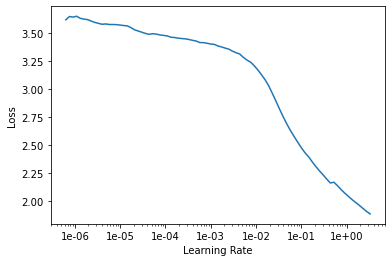

In [19]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(5, 3e-2, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.007891,0.009168,0.101222,00:08
1,0.008568,0.001760,0.039383,00:09
2,0.005378,0.000562,0.022648,00:08
3,0.002552,0.000465,0.016901,00:08
4,0.001763,0.000343,0.016895,00:08


In [21]:
learn.save('v1')

In [22]:
learn.fit_one_cycle(3,3e-5)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.001670,0.000541,0.019331,00:08
1,0.001494,0.000378,0.017923,00:08
2,0.001611,0.000560,0.019490,00:09


In [23]:
learn.fit_one_cycle(3,1e-6)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.001698,0.000422,0.015265,00:08
1,0.001798,0.000320,0.015109,00:08
2,0.001669,0.000500,0.018533,00:09


In [24]:
test_preds=learn.get_preds(DatasetType.Test)

In [25]:
torch.exp(test_preds[0][:20])

tensor([[95.7179],
        [96.5797],
        [95.3946],
        [95.8897],
        [96.1864],
        [96.0628],
        [95.8792],
        [96.1615],
        [95.8357],
        [71.2945],
        [71.4361],
        [71.2107],
        [71.2421],
        [71.3846],
        [71.4286],
        [70.9445],
        [70.8730],
        [71.5389],
        [71.2535],
        [71.2741]])

In [26]:
target_test[:20]

58436    95.71
58435    95.68
58432    95.48
58433    95.50
58438    95.79
58439    96.67
58434    95.57
58440    97.15
58437    95.77
58446    70.63
58442    70.38
58448    70.72
58447    70.72
58450    70.90
58454    71.77
58445    70.50
58443    70.39
58451    70.98
58449    70.72
58452    70.99
Name: finish_time_s, dtype: float64

In [27]:
learn.save('v2')

In [28]:
test_preds

[tensor([[4.5614],
         [4.5704],
         [4.5580],
         ...,
         [4.0684],
         [4.0742],
         [4.0691]]),
 tensor([0, 0, 0,  ..., 0, 0, 0])]

### Prize from betting hottest choice(lowest win odd in each race)

In [29]:
def get_place_prize(df):
    '''calculate the prize won by betting on place only, return net prize, prize won and number of race'''
    # get win price for all first place in test set
    hottest=df.loc[df.groupby(['season','race_id'])['win_odds'].idxmin()]
    wins=hottest[hottest['place']==1][['date','race_id','horse','win_odds']]

    # bet 10 dollars for each race
    prize_hottest=sum(wins['win_odds']*10)
    num_of_race=hottest.shape[0]
    result_hottest=prize_hottest-num_of_race*10
    return_rt=round(prize_hottest/(num_of_race*10)-1,2)
    
    return result_hottest,prize_hottest,num_of_race,return_rt

In [30]:
get_place_prize(df_pred)

(-2177.0, 7023.0, 920, -0.24)

### Prize from betting the shortest predicted finish time for each race

In [31]:
def get_predict_prize(df,pred):
    # get predict 
    df['predict']=torch.exp(pred[0])
    df['predict']=df['predict'].apply(lambda x:x[0].numpy()) #convert scaler tensor to float
    fastest=df.loc[df.groupby(['season','race_id'])['predict'].idxmin()]
    wins_pred=fastest[fastest['place']==1][['date','race_id','horse','win_odds']]
    wins_pred.sort_index().head(20)
    # bet 10 dollars for each race
    prize_fastest=sum(wins_pred['win_odds']*10)
    num_of_race=fastest.shape[0]
                                            
    result_fastest=prize_fastest-num_of_race*10
    result_fastest,prize_fastest,num_of_race
    return_rt = round(prize_fastest/(num_of_race*10)-1,2)
    return result_fastest,prize_fastest,num_of_race,return_rt

In [32]:
get_predict_prize(df_pred,test_preds)

(-986.0, 8214.0, 920, -0.11)

### Export model in pickle

In [33]:
learn.export('../data/models/horse_racing.pkl')

### Load learner to give prediction

In [34]:
learn2 = load_learner('../data/models','horse_racing.pkl')
learn2.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(6, 4)
    (1): Embedding(16, 8)
    (2): Embedding(3054, 143)
    (3): Embedding(131, 25)
    (4): Embedding(128, 24)
    (5): Embedding(18, 8)
    (6): Embedding(8, 5)
    (7): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=235, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.002, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=500, out_features=1, bias=True)
  )
)

In [35]:
single_test=test_df[cat_vars + cont_vars + ['date']].iloc[0]
single_test

season                             2019/2020
last_place                                 3
horse                            GOLD VELVET
jockey                            L Hewitson
trainer                          A T Millard
class                                Class 5
track                      TURF - "B" Course
location                             Sha Tin
actual_weight                            133
last_actual_weight                       133
draw                                       8
last_lbw                                 2.5
last_running_position                   6.75
distance_m                              1600
rest_day                                  53
pct_1st_last_j                             0
pct_2nd_last_j                             0
pct_3rd_last_j                             0
pct_4th_last_j                             0
pct_1st_last_t                          8.99
pct_2nd_last_t                           7.9
pct_3rd_last_t                         11.99
pct_4th_la

In [36]:
len(single_test)

24

In [37]:
test_set = test_df[cat_vars + cont_vars + ['date']]

In [38]:
res_pred=learn2.predict(test_set.iloc[0])
res_pred

(FloatItem [4.561405], tensor([4.5614]), tensor([4.5614]))

In [39]:
test_set.shape

(11296, 24)

In [40]:
test_set.iloc[0]

season                             2019/2020
last_place                                 3
horse                            GOLD VELVET
jockey                            L Hewitson
trainer                          A T Millard
class                                Class 5
track                      TURF - "B" Course
location                             Sha Tin
actual_weight                            133
last_actual_weight                       133
draw                                       8
last_lbw                                 2.5
last_running_position                   6.75
distance_m                              1600
rest_day                                  53
pct_1st_last_j                             0
pct_2nd_last_j                             0
pct_3rd_last_j                             0
pct_4th_last_j                             0
pct_1st_last_t                          8.99
pct_2nd_last_t                           7.9
pct_3rd_last_t                         11.99
pct_4th_la

In [41]:
test_df.iloc[0]

season                             2019/2020
race_id                                    1
race                                       1
date                     2019-09-01 00:00:00
place                                      5
last_place                                 3
horse_id                                V400
horse_no                                   1
horse                            GOLD VELVET
jockey                            L Hewitson
trainer                          A T Millard
actual_weight                            133
last_actual_weight                       133
declared_horse_weight                   1155
draw                                       8
last_lbw                                 2.5
last_running_position                   6.75
win_odds                                   7
class                                Class 5
going                                   GOOD
track                      TURF - "B" Course
prize                                 725000
location  

In [42]:
test_df.iloc[0].shape

(33,)

In [43]:
torch.exp(res_pred[2])

tensor([95.7179])

In [44]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11296 entries, 58436 to 69725
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   season                 11296 non-null  object        
 1   last_place             11296 non-null  float64       
 2   horse                  11296 non-null  object        
 3   jockey                 11296 non-null  object        
 4   trainer                11296 non-null  object        
 5   class                  11296 non-null  object        
 6   track                  11296 non-null  object        
 7   location               11296 non-null  object        
 8   actual_weight          11296 non-null  float64       
 9   last_actual_weight     11296 non-null  float64       
 10  draw                   11296 non-null  int64         
 11  last_lbw               11296 non-null  float64       
 12  last_running_position  11296 non-null  float64       
 1